# Analysis of Tesla stock market

## Universidad Nacional de Colombia - Sede Manizales


## Authors: Brandon Lotero Londoño & Juan Pablo Carmona Osorio
## Acknowledgment: César Germán Castellanos



In [ ]:
!pip install pyts hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 4.1 MB/s 
     |████████████████████████████████| 217 kB 58.7 MB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from ipywidgets import interact
import gdown

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pyts.decomposition import SingularSpectrumAnalysis

import tensorflow as tf

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

#from pomegranate import HiddenMarkovModel, NormalDistribution

from hmmlearn import hmm

%matplotlib inline

In [ ]:
URL = "https://drive.google.com/u/0/uc?id=11WiZuAtp3NXkUU25VpYO-2EjCBSEZze9&export=download"
fileName = "Tesla.csv"
gdown.download(URL, fileName)

Downloading...
From: https://drive.google.com/u/0/uc?id=11WiZuAtp3NXkUU25VpYO-2EjCBSEZze9&export=download
To: /content/Tesla.csv
100%|██████████| 175k/175k [00:00<00:00, 72.5MB/s]


'Tesla.csv'

In [ ]:
#We download and transform information to manipulate it
data  = pd.read_csv('Tesla.csv', index_col=0, parse_dates=True).dropna()
data.datetime = pd.to_datetime(data.index)
data["Year"] = data.index.year
data.head(5)

<ipython-input-4-68dcb2395825>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.datetime = pd.to_datetime(data.index)


,Open,High,Low,Close,Adj Close,Volume,Year
Date,,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300,2010
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100,2010
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800,2010
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800,2010
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900,2010


# Exploratory analysis

In [ ]:
data.describe()
"""
We analyze the description of the database
"""

'\nWe analyze the description of the database\n'

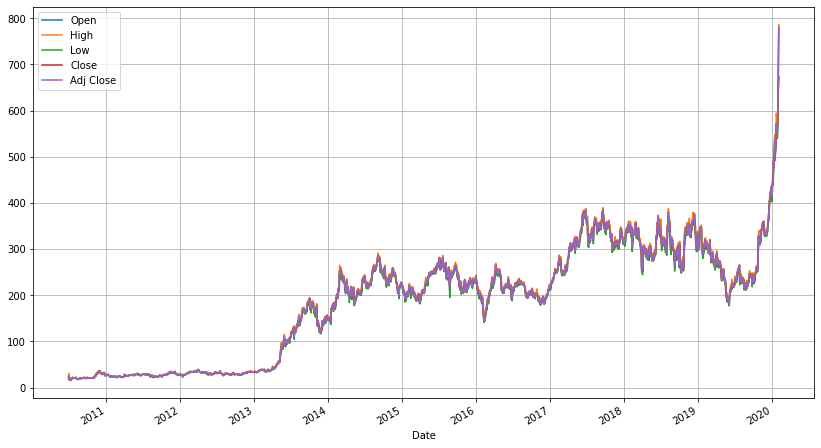

In [ ]:
data[['Open','High','Low','Close','Adj Close']].plot(figsize=(14,8), grid=True)
"""
We plot the database
"""
plt.show()

In [ ]:
plotters = {
    "boxplot": sns.boxplot,
    "violin": sns.violinplot
}

@interact(plot_style = ["violin", "boxplot"])
def plot_data_distribution(plot_style = "boxplot"):  
  fig_dims = (20, 6)  
  split_index = int(data.shape[0]/2)
  plotter = plotters[plot_style]

  fig, axes = plt.subplots(nrows = 1, ncols=2, figsize=fig_dims)
  data1 = data.iloc[:split_index]
  data2 = data.iloc[split_index:]
  plotter(ax=axes[0], data=data1, x="Year", y="Close")
  plotter(ax=axes[1], data=data2, x="Year", y="Close")
  axes[0].grid()
  axes[1].grid()
  axes[0].set_title(f"Close value for years {int(data1.iloc[0]['Year'])}-{int(data1.iloc[-1]['Year'])}")
  axes[1].set_title(f"Close value for years {int(data2.iloc[0]['Year'])}-{int(data2.iloc[-1]['Year'])}")

interactive(children=(Dropdown(description='plot_style', index=1, options=('violin', 'boxplot'), value='boxplo…

In [ ]:
def custom_timeseries_splitter(X, y, test_size = 0.1):
    totalSamples = y.shape[0]
    train_limit_index = int(totalSamples * ( 1 - test_size))    
    X_train = np.array(X[:train_limit_index])
    X_test = np.array(X[train_limit_index:])
    y_train = np.array(y[:train_limit_index])
    y_test = np.array(y[train_limit_index:])
    
    return X_train, X_test, y_train, y_test, train_limit_index
    

In [ ]:
input_params = ['Open']

In [ ]:
X = np.array(data[input_params])
y = data['Close']

y_arr = np.array(y)
X_train, X_test, y_train, y_test, train_limit_index = custom_timeseries_splitter(X, y, test_size=0.3)


In [ ]:
scaler = StandardScaler().fit(X_train)

In [ ]:
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)

LinearRegression()

In [ ]:
linearModel.__dict__

{'fit_intercept': True,
 'normalize': 'deprecated',
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'n_features_in_': 1,
 'coef_': array([0.99928879]),
 '_residues': 23051.02690988227,
 'rank_': 1,
 'singular_': array([3875.95764597]),
 'intercept_': 0.0826957977160987}

In [ ]:
y_test_predict_linear_model = linearModel.predict(X_test)

In [ ]:
def compare_prediction(y_test, y_test_predict, winInit, winEnd):
    err = y_test - y_test_predict
    abserr = np.abs(err)
    plt.figure(figsize=(14,7))
    plt.subplot(311)
    plt.plot(y_test[winInit:winEnd], label='Original')
    plt.plot(y_test_predict[winInit:winEnd], label='Prediction')
    plt.legend()
    plt.grid()
    plt.subplot(312)
    plt.plot(err[winInit:winEnd], label='Error')
    plt.legend()
    plt.grid()
    plt.subplot(313)
    plt.plot(abserr[winInit:winEnd], label='Absolute Error')
    plt.legend()
    plt.grid()
    plt.show()
    print(f"Normalized error mean: {err.mean()/(err.max() - err.min())}")
    print(f"Normalized mean squared error: {mse(y_test_predict, y_test) / (y_test.max() - y_test.min()) }")

In [ ]:
@interact(winInit = (0,int(0.8 * y_test.shape[0]),100), winEnd = (0,int(0.8 * y_test.shape[0]), 100))
def showPredictionPlot(winInit = 0, winEnd = int(0.1 * y_test.shape[0])):
  compare_prediction(y_test, y_test_predict_linear_model, winInit, winEnd)


interactive(children=(IntSlider(value=0, description='winInit', max=580, step=100), IntSlider(value=72, descri…

# Data preprocessing

## Seasonal decomposition

In [ ]:
data_freq_split = data.groupby(pd.Grouper(freq='W')).mean() # freq = 'M', 'W'

x_seasonal_decomposed = seasonal_decompose(x=data_freq_split['Open'], model='additive')
y_seasonal_decomposed = seasonal_decompose(x=data_freq_split['Close'], model='additive')

X_trend = np.array(x_seasonal_decomposed.trend).reshape(-1,1)
X_seasonal = np.array(x_seasonal_decomposed.seasonal).reshape(-1,1)
X_residual = np.array(x_seasonal_decomposed.resid).reshape(-1,1)


y_trend = np.array(y_seasonal_decomposed.trend).reshape(-1,1)
y_seasonal = np.array(y_seasonal_decomposed.seasonal).reshape(-1,1)
y_residual = np.array(y_seasonal_decomposed.resid).reshape(-1,1)

Normalized error mean: 0.004512197755917376
Normalized mean squared error: 0.12312325584503298


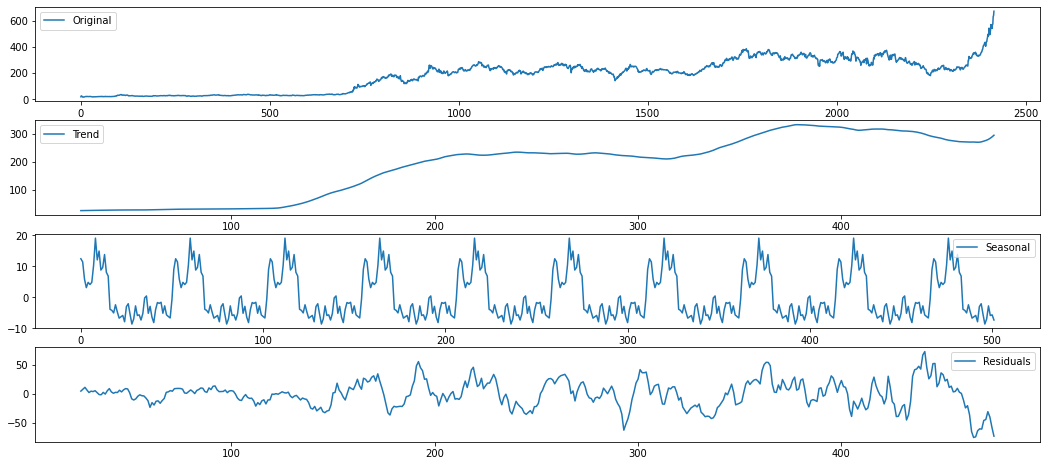

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(411)
plt.plot(X, label='Original')
plt.legend()
plt.subplot(412)
plt.plot(X_trend, label='Trend', )
plt.legend()
plt.subplot(413)
plt.plot(X_seasonal, label='Seasonal')
plt.legend()
plt.subplot(414)
plt.plot(X_residual, label='Residuals')
plt.legend()

In [ ]:
X.shape

(2416, 1)

In [ ]:
X1=X.reshape(-1)

## SSA decomposition

In [ ]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

In [ ]:
# For plotting purposes:
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [ ]:
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

In [ ]:
ssa = SingularSpectrumAnalysis(window_size=180)
X_ssa = ssa.fit_transform(X.T)
# chose de window for SSA

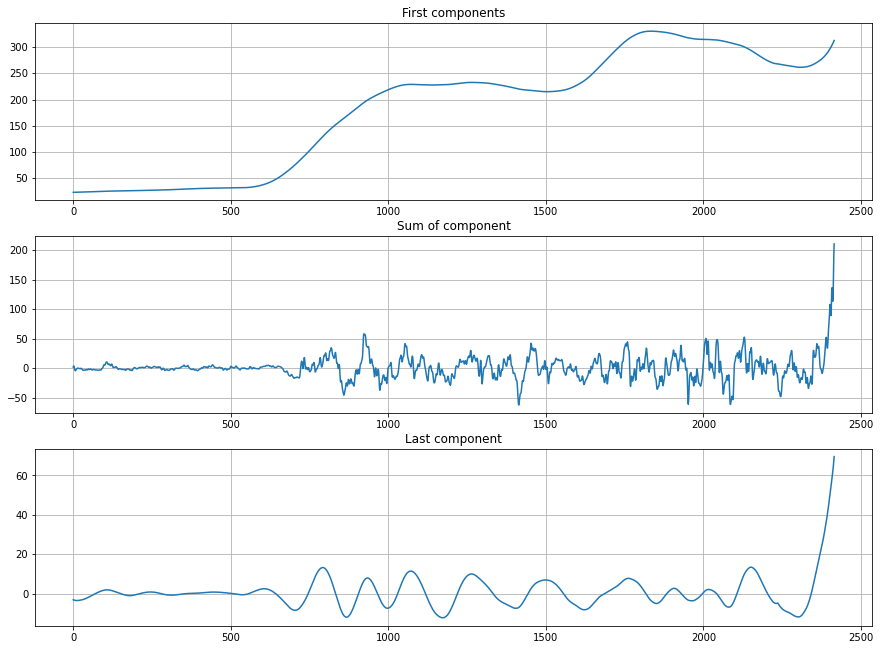

In [ ]:
x_ssa_t = X_ssa.T

plt.figure(figsize = (15,15))
plt.subplot(411)
#Chose the trend whit the principal components
plt.plot(x_ssa_t[:,0])
plt.grid()
plt.title("First components")
#Calculated the sum of component 
plt.subplot(412)
plt.plot(np.sum(x_ssa_t[:,2:60], axis=1))
plt.grid()
plt.title("Sum of component")
#For the noise the last component
plt.subplot(413)
plt.plot(x_ssa_t[:,2])
plt.grid()
plt.title("Last component")



plt.show()

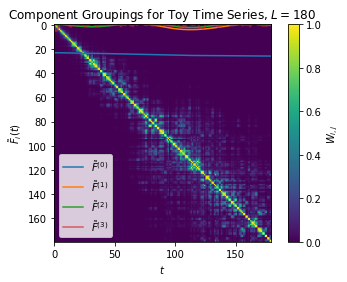

In [ ]:
F_ssa_L180 = SSA(X1, 180)
F_ssa_L180.plot_wcorr()
#to see the seasonality and be able to group them
plt.title("W-Correlation for Toy Time Series, $L=40$");
F_ssa_L180.reconstruct(0).plot()
F_ssa_L180.reconstruct([1,2,3]).plot()
F_ssa_L180.reconstruct([4,5]).plot()
F_ssa_L180.reconstruct(slice(17,180)).plot(alpha=0.7)
plt.title("Component Groupings for Toy Time Series, $L=180$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(4)]);

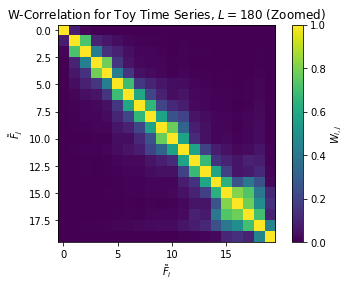

In [ ]:
F_ssa_L180.plot_wcorr(max=19)
#to see the seasonality in a specific window
plt.title("W-Correlation for Toy Time Series, $L=180$ (Zoomed)");

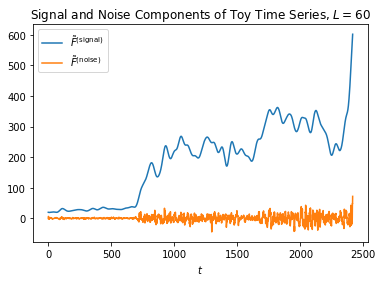

In [ ]:
F_ssa_L180 = SSA(X1, 180)
F_ssa_L180.reconstruct(slice(0,7)).plot()
F_ssa_L180.reconstruct(slice(7,180)).plot()
#The decomposition of each part of the signal into its main signal components and noise
plt.legend([r"$\tilde{F}^{\mathrm{(signal)}}$", r"$\tilde{F}^{\mathrm{(noise)}}$"])
plt.title("Signal and Noise Components of Toy Time Series, $L = 60$")
plt.xlabel(r"$t$");

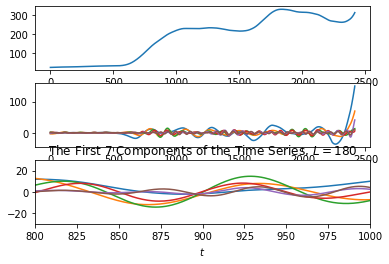

In [ ]:
fix, axes = plt.subplots(ncols=1, nrows=3)

ssa_ans = F_ssa_L180.components_to_df(n=7)

axes[0].plot(ssa_ans['F0'])
axes[1].plot(ssa_ans.drop('F0', axis=1))
axes[2].plot(ssa_ans.drop('F0', axis=1))
plt.title(r"The First 7 Components of the Time Series, $L=180$")
#Separation of the first 7 signal components and zoom
axes[2].plot(plt.ylim(-30,30))
axes[2].plot(plt.xlim(800,1000))
axes[2].plot(label="Zomed",axis=2)
plt.xlabel(r"$t$");


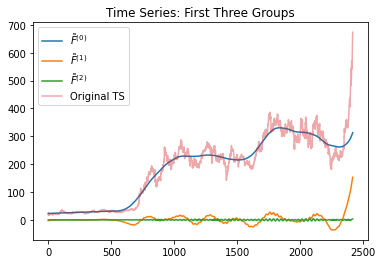

In [ ]:
F_ssa_L180.reconstruct(0).plot()
F_ssa_L180.reconstruct([1,12]).plot()
F_ssa_L180.reconstruct([12,179]).plot()
F_ssa_L180.orig_TS.plot(alpha=0.4)
#Based on the above information we take the components indicated for each group
plt.title("Time Series: First Three Groups")
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);

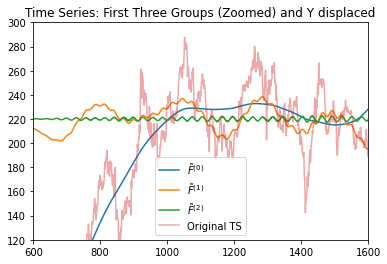

In [ ]:
F_ssa_L180.reconstruct(0).plot()
(F_ssa_L180.reconstruct([1,12])+220).plot()
(F_ssa_L180.reconstruct([12,179])+220).plot()
F_ssa_L180.orig_TS.plot(alpha=0.4)
#zoom in the area and move the signals with mean 0 to have a proper visualization
plt.title("Time Series: First Three Groups (Zoomed) and Y displaced")
plt.xlim(600,1600)
plt.ylim(120, 300)
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);


(125.0, 300.0)

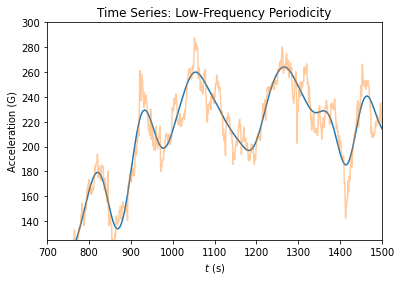

In [ ]:
F_ssa_L180.reconstruct(slice(0,5)).plot()
F_ssa_L180.orig_TS.plot(alpha=0.4)
#to see the periodicity in low frequencies
plt.title("Time Series: Low-Frequency Periodicity")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.xlim(700,1500)
plt.ylim(125, 300)

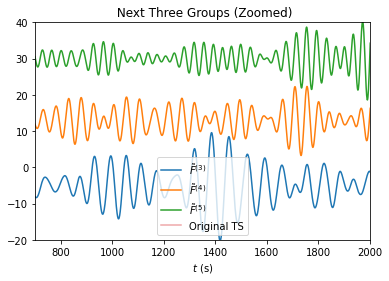

In [ ]:
(F_ssa_L180.reconstruct([5,6])-5).plot()
(F_ssa_L180.reconstruct([7,8]) + 13).plot() # Note: adding 13 to the series is for visualisation purposes only!
(F_ssa_L180.reconstruct([9,10]) + 30).plot() # Note: adding 30 to the series is for visualisation purposes only!
SSA_Ans=F_ssa_L180.orig_TS.plot(alpha=0.4)
#For visualisation purposes only we scroll the following 3 groups of components
plt.title(" Next Three Groups (Zoomed)")
plt.xlabel(r"$t$ (s)")
plt.xlim(700,2000)
plt.ylim(-20, 40)
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3,6)] + ["Original TS"]
plt.legend(legend);

(125.0, 300.0)

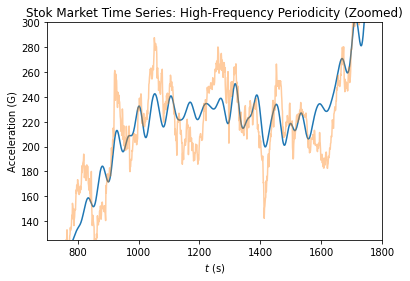

In [ ]:
F_ssa_L180.reconstruct([0] + [i for i in range(5,11)]).plot()
F_ssa_L180.orig_TS.plot(alpha=0.4)
#to see the periodicity in High frequencies 
plt.title("Stok Market Time Series: High-Frequency Periodicity (Zoomed)")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.xlim(700,1800)
plt.ylim(125, 300)

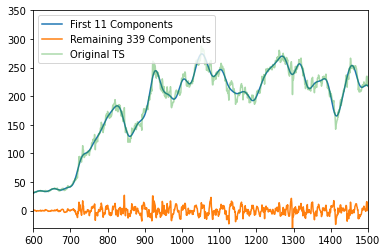

In [ ]:
F_ssa_L180.reconstruct(slice(0,11)).plot()
F_ssa_L180.reconstruct(slice(11,350)).plot()
F_ssa_L180.orig_TS.plot(alpha=0.4)
#The signal is divided among the first 11 components that store most of the information of the following noise-carrying components
plt.ylim(-30, 350)
plt.xlim(600,1500)
plt.legend(["First 11 Components", "Remaining 339 Components", "Original TS"]);

Pruebas new SSA

In [ ]:

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

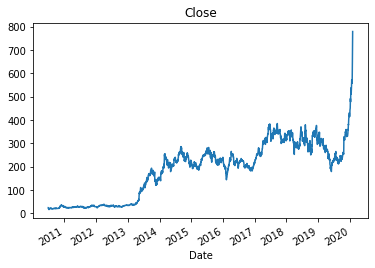

In [ ]:

df = data
df.index = pd.to_datetime(df.index)
y = df["Close"]
y.name = "Close"

y.plot(title="Close");

In [ ]:

# create the DF
seasonal_df = y.to_frame()

# calculate the trend component
seasonal_df["trend"] = seasonal_df["Close"].rolling(window=13, center=True).mean()

# detrend the series
seasonal_df["detrended"] = seasonal_df["Close"] - seasonal_df["trend"]

# calculate the seasonal component
seasonal_df.index = pd.to_datetime(seasonal_df.index)
seasonal_df["month"] = seasonal_df.index.month
seasonal_df["seasonality"] = seasonal_df.groupby("month")["detrended"].transform("mean")

# get the residuals
seasonal_df["resid"] = seasonal_df["detrended"] - seasonal_df["seasonality"]

# display the DF
seasonal_df.head(15)

,Close,trend,detrended,month,seasonality,resid
Date,,,,,,
2010-06-29,23.889999,NaN,NaN,6,0.511494,NaN
2010-06-30,23.830000,NaN,NaN,6,0.511494,NaN
2010-07-01,21.959999,NaN,NaN,7,-0.678038,NaN
2010-07-02,19.200001,NaN,NaN,7,-0.678038,NaN
2010-07-06,16.110001,NaN,NaN,7,-0.678038,NaN
2010-07-07,15.800000,NaN,NaN,7,-0.678038,NaN
2010-07-08,17.459999,19.323846,-1.863847,7,-0.678038,-1.185809
2010-07-09,17.400000,19.171538,-1.771538,7,-0.678038,-1.093500
2010-07-12,17.049999,18.900000,-1.850001,7,-0.678038,-1.171963


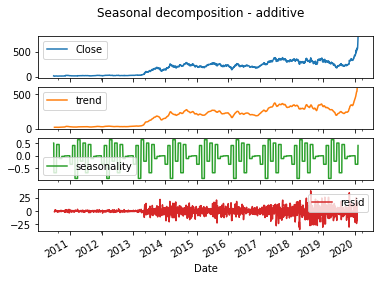

In [ ]:
(
    seasonal_df
    .loc[:, ["Close", "trend", "seasonality", "resid"]]
    .plot(subplots=True, title="Seasonal decomposition - additive")
);

# First approach: train with preprocessed data with simple Linear Model

In [ ]:
X_train_ssa = ssa.fit_transform(X_train.T)[0].reshape(-1, 1)
linearModel.fit(X_train_ssa, y_train)
#train with preprocessed data with simple Linear Model

LinearRegression()

In [ ]:
@interact(winInit = (0,int(0.8 * y_test.shape[0]),100), winEnd = (0,int(0.8 * y_test.shape[0]), 100))
def showPredictionPlot(winInit = 0, winEnd = y_test.shape[0]):
  compare_prediction(y_test, y_test_predict_linear_model, winInit, winEnd)
  #Compare the prediction whit interact of user

interactive(children=(IntSlider(value=0, description='winInit', max=580, step=100), IntSlider(value=580, descr…

# Second approach: Symbolization and Hidden Markov Models

In [ ]:
def remove_nan(array):
  return array[~np.isnan(array).any(axis=1)]

In [ ]:
X_train_trend, X_test_trend, y_train_trend, y_test_trend,_ = custom_timeseries_splitter(X_trend, y_trend, test_size=0.3)
X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal,_ = custom_timeseries_splitter(X_seasonal, y_seasonal, test_size=0.3)
X_train_residual, X_test_residual, y_train_residual, y_test_residual,_ = custom_timeseries_splitter(X_residual, y_residual, test_size=0.3)
X_train_trend = remove_nan(X_train_trend)
X_train_seasonal = remove_nan(X_train_seasonal)
X_train_residual = remove_nan(X_train_residual)
#Pre-prossesing data to Symbolization and Hidden Markov Models

In [ ]:
class Symbolizer():
  def __init__(self):
        pass
  def transform(self, data, n_symbols):
    pass

class UniformSymbolizer(Symbolizer):
    def __init__(self):
        pass
    def transform(self, data, n_symbols = 10):
        min_point = data.min()        
        max_point = data.max()
        output_symbols = []
        output_values = []
        steps = np.linspace(min_point, max_point, n_symbols)        
        for i in range(data.shape[0]):            
            diff = np.abs(steps - data[i])
            symbol = np.argmin(diff)            
            output_symbols.append(symbol)            
            output_values.append(steps[symbol])
        return np.array(output_symbols), np.array(output_values)

class LogSymbolizer(Symbolizer):
    def __init__(self):
        pass
    def transform(self, data, n_symbols = 10):
        min_point = data.min()   #Minimum data from the database 
        max_point = data.max() #Maximun data from the database 
        output_symbols = [] #Output for the symbols
        output_values = []
        base = ( max_point / min_point ) ** (1 / n_symbols)        #Base of transform
        steps = np.logspace(np.log10(min_point), np.log10(max_point), n_symbols)        
        for i in range(data.shape[0]):            
            diff = np.abs(steps - data[i])
            symbol = np.argmin(diff)            
            output_symbols.append(symbol)            
            output_values.append(steps[symbol])
        return np.array(output_symbols), np.array(output_values) #Returns the array of symbols

In [ ]:
@interact(winInit = (0,int(X_train_trend.shape[0]), 100), winEnd = (0,int(X_train_trend.shape[0]), 100))
def showSymbolsPlot(winInit = 0, winEnd = X_train_trend.shape[0]):
    X_frac = X_train_trend[winInit:winEnd]    
    uniformSymb = UniformSymbolizer()
    logSymb = LogSymbolizer()
    X_train_symbol_lin, X_train_symbol_values_lin = uniformSymb.transform(X_frac)    
    X_train_symbol_log, X_train_symbol_values_log = logSymb.transform(X_frac)
    plt.figure(figsize=(15,7))
    plt.plot(X_train_symbol_values_lin, label = 'Symbolized data (linear symbols)')
    plt.plot(X_train_symbol_values_log, label = 'Symbolized data (log symbols)')
    plt.plot(X_frac, label = 'Time series data')
    plt.grid()
    plt.legend()
    plt.show()
    #Plot the Symbolized data whit Linea Symbols and Log Symbols whit Time series Data

interactive(children=(IntSlider(value=0, description='winInit', max=325, step=100), IntSlider(value=325, descr…

## Implementing Hidden Markov Models on components obtained from seasonal decomposition

In [ ]:
def implement_markov(input_data, symbolizer, n_symbols=4):
  if not isinstance(symbolizer, Symbolizer):
    raise Exception("Incoming symbolizer must be an instance from class Symbolizer")
  train_symbols,_ = symbolizer.transform(input_data,  n_symbols = n_symbols)  #Transform symbolizer 
  train_symbols_reshaped = train_symbols.reshape(-1,1) #Reshape the train
  model = hmm.GaussianHMM(n_components = n_symbols, covariance_type = "diag", n_iter = 50, random_state = 42) #GaussianHMM
  model.fit(input_data)
  return model, train_symbols #Return the model and the symbols trained

def plot_symbols(symbol_groups, labels): #Plot the symbol_groups
  if len(symbol_groups) is not len(labels):
    raise Exception("Length of models and labels must have the same lenght")
  total_plots = len(labels)
  fig, ax = plt.subplots(nrows = total_plots, ncols = 1, figsize=(18,10))
  
  for i, (symbol_group,label) in enumerate(list(zip(symbol_groups, labels))):    
    ax[i].plot(symbol_group)
    ax[i].set_title(label)
    fig.show()    


def plot_markov_matrixes(models, labels): #Plot the markov matrixes
  if len(models) is not len(labels):
    raise Exception("Length of models and labels must have the same lenght")
  fig, ax = plt.subplots(nrows = 1, ncols = len(labels), figsize=(18,5))
  
  for i, (model,label) in enumerate(list(zip(models, labels))):
    transition_matrix = model.transmat_
    sns.heatmap(transition_matrix, ax = ax[i])
    ax[i].set_title(label)
    fig.show()    

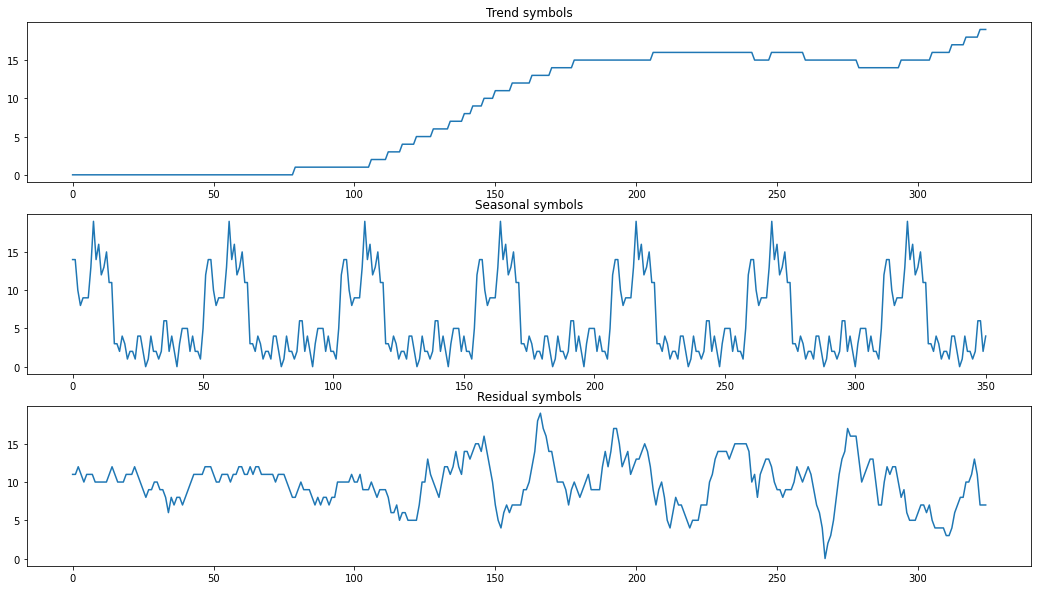

In [ ]:
n_symbols = 20
trend_model, trend_symbols = implement_markov(np.array(X_train_trend), UniformSymbolizer(), n_symbols=n_symbols)
seasonal_model, seasonal_symbols = implement_markov(np.array(X_train_seasonal), UniformSymbolizer(), n_symbols=n_symbols)
residual_model, residual_symbols = implement_markov(np.array(X_train_residual), UniformSymbolizer(), n_symbols=n_symbols)

plot_symbols([trend_symbols, seasonal_symbols, residual_symbols], ["Trend symbols","Seasonal symbols", "Residual symbols"])

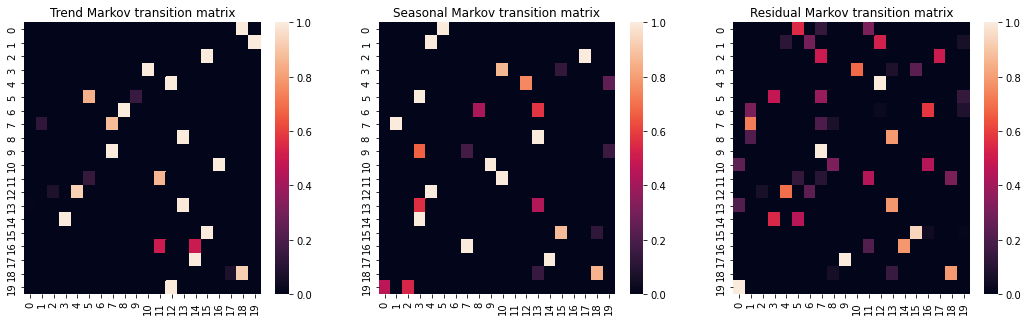

In [ ]:
plot_markov_matrixes([trend_model, seasonal_model, residual_model], ["Trend Markov transition matrix", 
                                                                     "Seasonal Markov transition matrix", 
                                                                     "Residual Markov transition matrix"])

# Third approach: Auto regressive models

First, let's find out if the time series is stationary through an adfuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.400069
p-value: 0.997114


Therefore the hipothesis that the time series is stationary, is discarded

### Choosing ideal values for ARIMA model order parameters

In [ ]:
data.value = y

<ipython-input-50-176fc615d514>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.value = y


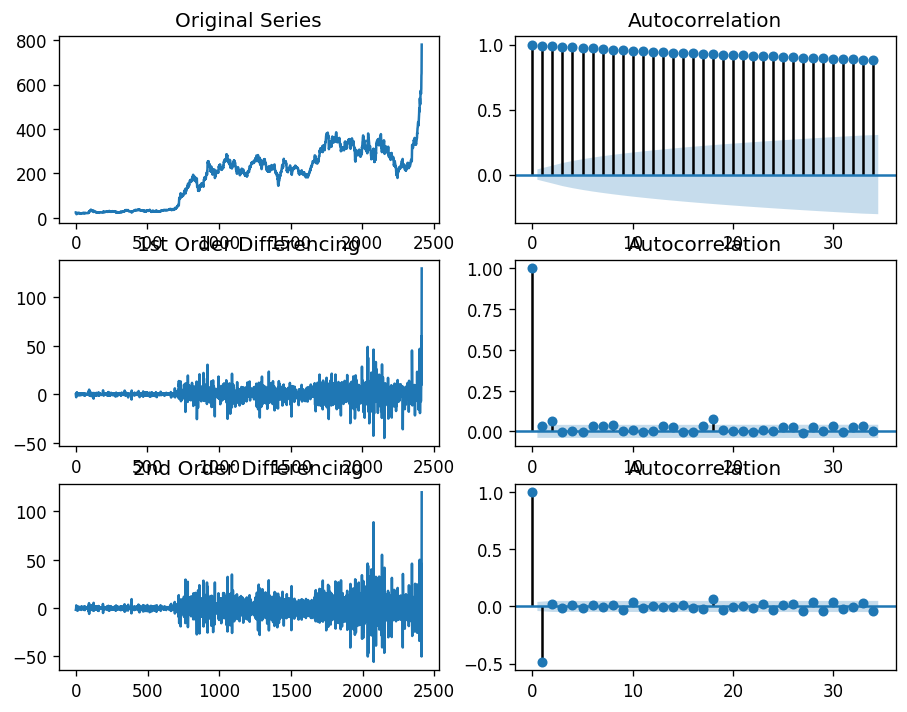

In [ ]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

y_diff = np.diff(y_arr)
y_diff2 = np.diff(y_diff)

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(y_arr); axes[0, 0].set_title('Original Series')
plot_acf(y_arr, ax=axes[0, 1])

# 1st DifferencingT
axes[1, 0].plot(y_diff); axes[1, 0].set_title('1st Order Differencing')
plot_acf(y_diff, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y_diff2); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y_diff2, ax=axes[2, 1])


plt.show()

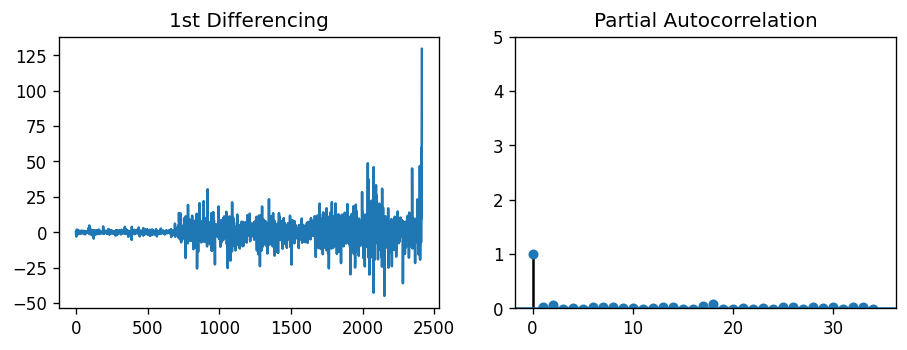

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_diff); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

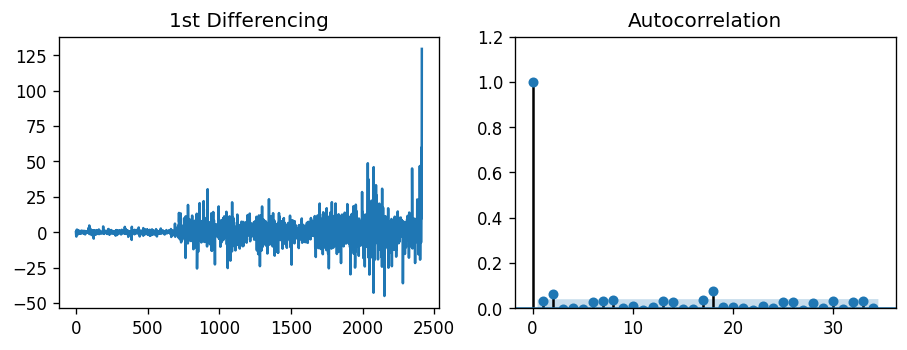

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data and see the diference 

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_diff); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(y_diff, ax=axes[1])

plt.show()

In [ ]:
p = 3
d = 1
q = 18

order = (p,d,q)

arima_model = ARIMA(y_train, order = order)#Chose de ARIMA Model
arima_result_model = arima_model.fit()
arima_result_model.summary()


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1691
Model:                ARIMA(3, 1, 18)   Log Likelihood               -4890.923
Date:                Thu, 08 Dec 2022   AIC                           9825.846
Time:                        20:53:48   BIC                           9945.361
Sample:                             0   HQIC                          9870.104
                               - 1691                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1796      0.398     -0.451      0.652      -0.960       0.601
ar.L2          0.1128      0.439      0.257      0.797      -0.749       0.974
ar.L3          0.7856      0.343      2.289      0.022       0.113       1.458
ma.L1          0.2110      0.396      0.533      0.594      -0.566       0.988
ma.L2         -0.1111      0.452     -0.246      0.806      -0.997       0.775
ma.L3         -0.8110      0.357     -2.269      0.023      -1.512      -0.111
ma.L4         -0.0555      0.024     -2.272      0.023      -0.103      -0.008
ma.L5          0.0120      0.035      0.340      0.734      -0.057       0.081
ma.L6         -0.0048      0.035     -0.138      0.890      -0.073       0.063
ma.L7          0.0319      0.027      1.188      0.235      -0.021       0.084
ma.L8          0.0349      0.026      1.320      0.187      -0.017       0.087
ma.L9          0.0340      0.031      1.084      0.278      -0.027       0.095
ma.L10         0.0088      0.035      0.254      0.799      -0.059       0.077
ma.L11        -0.0200      0.036     -0.556      0.578      -0.090       0.050
ma.L12         0.0004      0.027      0.015      0.988      -0.053       0.054
ma.L13        -0.0443      0.028     -1.568      0.117      -0.100       0.011
ma.L14        -0.0052      0.026     -0.199      0.843      -0.057       0.047
ma.L15        -0.0062      0.026     -0.239      0.811      -0.057       0.045
ma.L16         0.0478      0.021      2.323      0.020       0.007       0.088
ma.L17        -0.0193      0.031     -0.623      0.533      -0.080       0.041
ma.L18         0.0036      0.025      0.146      0.884      -0.045       0.052
sigma2        19.1112      0.332     57.623      0.000      18.461      19.761
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3529.33
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              27.47   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

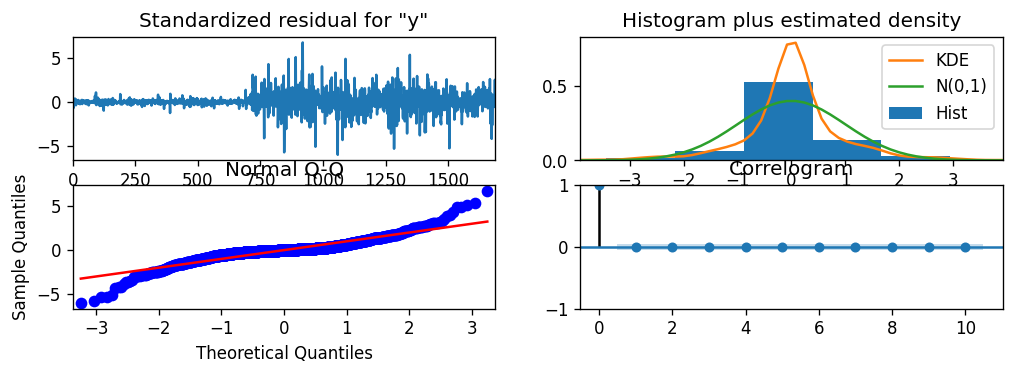

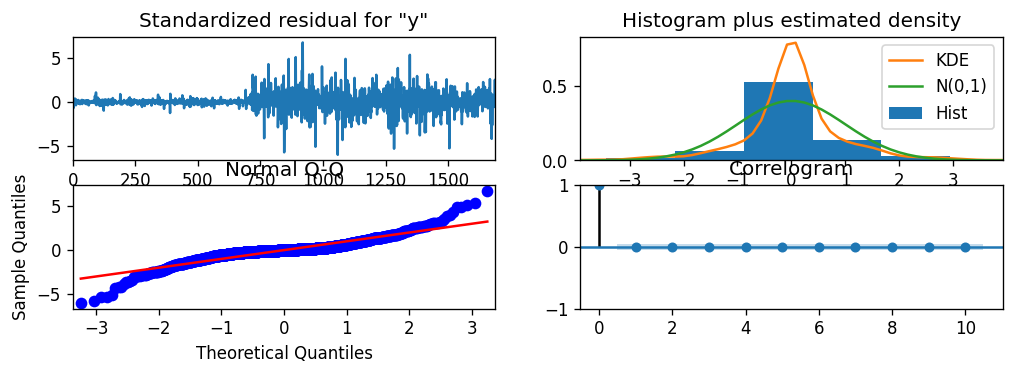

In [ ]:
fig = plt.figure(figsize=(10,3))
arima_result_model.plot_diagnostics(fig=fig)#Diagnostic for the ARIMA Model

### Prediction results

In [ ]:
arima_pred_output = arima_result_model.predict()
#Predicion for values in train set whit user interact
@interact(winInit = (0,int(y_train.shape[0]), 100), winEnd = (0,int(y_train.shape[0]), 100))
def plot_arima_pred_result(winInit = 1400, winEnd = y_train.shape[0]):
  fig = plt.figure(figsize=(18,7))
  plt.plot(y_train[winInit:winEnd], label = 'Original')
  plt.plot(arima_pred_output[winInit:winEnd], label = 'Prediction')
  plt.legend()
  plt.title("Predicion for values in train set")
  plt.grid()
  plt.show()

interactive(children=(IntSlider(value=1400, description='winInit', max=1691, step=100), IntSlider(value=1691, …

### Forecast results

In [ ]:
steps = y_test.shape[0]

forecast_output = arima_result_model.predict(start=0, end=y_arr.shape[0]) #Plot the Arima result to Forecast output 
concatenated_forecast = np.concatenate((y_train, forecast_output))

#try the Forecast for this database
@interact(winInit = (0,int(y_arr.shape[0]), 10), winEnd = (0,int(y_arr.shape[0]), 10))
def plot_arima_forecast_result(winInit = 1400, winEnd = y_arr.shape[0]):
  plt.figure(figsize=(18,5))
  x = np.linspace(winInit, winEnd, winEnd - winInit)
  plt.plot(x, y_arr[winInit:winEnd], label='Original full data')
  plt.plot(x, concatenated_forecast[winInit:winEnd], label='Concatenated forecast')
  effective_index = train_limit_index - winInit
  plt.grid()
  plt.legend()
  if effective_index >0:
    plt.vlines(train_limit_index, 0, 800, linestyles ="dashed", colors ="k")

interactive(children=(IntSlider(value=1400, description='winInit', max=2416, step=10), IntSlider(value=2416, d…

## Running with only trend components

In [ ]:
p = 3
d = 1
q = 1

order = (p,d,q)

arima_model_trend = ARIMA(y_train_trend, order = order)
arima_result_model_trend = arima_model.fit()
arima_result_model_trend.summary()

#Again see the ARIMA result Model

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1691
Model:                ARIMA(3, 1, 18)   Log Likelihood               -4890.923
Date:                Thu, 08 Dec 2022   AIC                           9825.846
Time:                        20:53:04   BIC                           9945.361
Sample:                             0   HQIC                          9870.104
                               - 1691                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1796      0.398     -0.451      0.652      -0.960       0.601
ar.L2          0.1128      0.439      0.257      0.797      -0.749       0.974
ar.L3          0.7856      0.343      2.289      0.022       0.113       1.458
ma.L1          0.2110      0.396      0.533      0.594      -0.566       0.988
ma.L2         -0.1111      0.452     -0.246      0.806      -0.997       0.775
ma.L3         -0.8110      0.357     -2.269      0.023      -1.512      -0.111
ma.L4         -0.0555      0.024     -2.272      0.023      -0.103      -0.008
ma.L5          0.0120      0.035      0.340      0.734      -0.057       0.081
ma.L6         -0.0048      0.035     -0.138      0.890      -0.073       0.063
ma.L7          0.0319      0.027      1.188      0.235      -0.021       0.084
ma.L8          0.0349      0.026      1.320      0.187      -0.017       0.087
ma.L9          0.0340      0.031      1.084      0.278      -0.027       0.095
ma.L10         0.0088      0.035      0.254      0.799      -0.059       0.077
ma.L11        -0.0200      0.036     -0.556      0.578      -0.090       0.050
ma.L12         0.0004      0.027      0.015      0.988      -0.053       0.054
ma.L13        -0.0443      0.028     -1.568      0.117      -0.100       0.011
ma.L14        -0.0052      0.026     -0.199      0.843      -0.057       0.047
ma.L15        -0.0062      0.026     -0.239      0.811      -0.057       0.045
ma.L16         0.0478      0.021      2.323      0.020       0.007       0.088
ma.L17        -0.0193      0.031     -0.623      0.533      -0.080       0.041
ma.L18         0.0036      0.025      0.146      0.884      -0.045       0.052
sigma2        19.1112      0.332     57.623      0.000      18.461      19.761
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3529.33
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              27.47   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
steps = y_test.shape[0]

y_trend_arr = y_trend.reshape(-1)

forecast_output = arima_result_model_trend.predict(start=0, end=y_trend_arr.shape[0]) #Output of forecast
concatenated_forecast = np.concatenate((y_trend_arr, forecast_output))


@interact(winInit = (0,int(y_trend_arr.shape[0]), 10), winEnd = (0,int(y_trend_arr.shape[0]), 10))
def plot_arima_forecast_result(winInit = 0, winEnd = y_trend_arr.shape[0]): #Plot the Arima Forecast result whit User interact
  plt.figure(figsize=(18,5))
  x = np.linspace(winInit, winEnd, winEnd - winInit)
  plt.plot(x, y_trend_arr[winInit:winEnd], label='Original full data')
  plt.plot(x, concatenated_forecast[winInit:winEnd], label='Concatenated forecast')
  effective_index = y_trend_arr.shape[0] -  forecast_output.shape[0]
  plt.grid()
  plt.legend()
  if effective_index >0:
    plt.vlines(train_limit_index, 0, 800, linestyles ="dashed", colors ="k")

interactive(children=(IntSlider(value=0, description='winInit', max=502, step=10), IntSlider(value=502, descri…

# Gaussian Process regressor

In [ ]:
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel